# Sentiment Analysis of Employee Performance Feedback


## Project Definition

The data for this project is based on employee feedback and annual performance reviews. A nine-box rating is used which measures both Performance and Potential.  This project will attempt to include a sentiment score as part of the NLP prediction to determine if the predictability can be improved.

Data was obtained from [Kaggle](https://www.kaggle.com/datasets/fiodarryzhykau/employee-review) where the contributor tested a variety of algorithms to find a model that best predicts the rating. The best predictive accuracy was 30%.

Other code in this repository (Sentiment_Scoring_Analysis.ipynb) determined Flair is the best package for scoring this employee performance data.  Will the inclusion of a sentiment score improve the predictive accuracy? 



## High Level Process

> Load data

> Calculate Sentiment Score

> Tokenize text 

> XGBoost with Grid Search
>>Test with and without OrdinalClassifier()







## Load Data

In [1]:
#load libraries
import pandas as pd
import numpy as np
def load_data(target):
    
    '''
    
    Data for this project was obtained via Kaggle (https://www.kaggle.com/datasets/fiodarryzhykau/employee-review)
    On Kaggle, the data had been separated into train & test and stored in 2 separate files. 
    For this project the files will be merged. Train & test data will be generated within the code. 
        
    INPUT - 
        target - y value to predict.  This could be the Category, Performance or Potential value. 
        
    OUTPUT - 
        X & y values for model prediction. 
    
    '''
    
    kaggle_data_test = pd.read_csv('./data/employee_review_mturk_dataset_test_v6_kaggle.csv')

    kaggle_data_train = pd.read_csv('./data/employee_review_mturk_dataset_v10_kaggle.csv')

    kaggle_data = [kaggle_data_test, kaggle_data_train.rename(columns={'adjusted':'updated'})]

    df = pd.concat(
        kaggle_data,
        axis=0,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,

        )

    #Split the 'nine_box_category' into 3 columsn ->  'performance' ,  'potential' and 'category'

    #split performance & potential values and clean to only include the Low, Moderate, High text 
    df[['performance', 'potential']] = df['nine_box_category'].str.split(',', 1, expand=True)
    df['performance'] = df['performance'].str.split('(').str[1].str.split(' ').str[0]
    df['potential'] = df['potential'].str.split(')').str[0].str.split(' ').str[1]

    #split nine_box_category string and clean 'category'
    #text before colon
    df['category'] = df['nine_box_category'].str.split(':').str[0]
    #text after space
    df['category'] = df['category'].str.split(' ').str[1]

    #Drop unnecessary columns 
    df.drop(['nine_box_category'], axis=1, inplace=True)
    
    #Keep only records with feedback text
    df['feedback'].dropna(inplace=True)
    
    #Remove rows that contain no characters
    df = df[df['feedback'].str.contains('[A-Za-z]')]
    
    
    #For testing - to limit size of dataset
    #df=df.sample(n = 50)
        
    X = df[['feedback','updated','reviewed']]
    
    y = df[target]
    
    return X, y 
    
    
    

## Clean Text and Build Tokenizer

In [2]:
import re
import string
from nltk.tokenize import word_tokenize, punkt
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import contractions
      
def tokenize(text):
    
    '''
    Process data to remove puncuation, normalize text (lower case) & tokenize data.
    Stop words are retained. Words like 'not' must be included for sentiment.
    Expand contractions before removing non-ASCII characters. 
    
    INPUT - 
        'text' - employee feedback text response
           
    OUTPUT - 
        'clean_tokens' - text has been cleaned and transformed into tokens 
    
    '''
    
    lemmatizer = WordNetLemmatizer()
    
    #Expand contractions before removing special char
    contractions.fix(text)
    
    #Remove non-Ascii characters 
    tokens = re.sub(r'[^\x00-\x7f]',r' ', str(text))
    
    #split by white space
    tokens = re.sub(r"[^\w\s]", " ", str(text))
    tokens = word_tokenize(tokens)
    #print(tokens)
    
    #Part of speech tagging
    tokens = pos_tag(tokens) 
    #print(tokens)
    
    #Remove proper nouns
    clean_pos_tokens = [x for (x,y) in tokens if y not in ('NNP', 'NNPS')]
    
    #lemmatize verbs
    clean_verb_tokens =  [lemmatizer.lemmatize(word,pos='v') for word in clean_pos_tokens ]
    
    #lemmatize nouns
    clean_tokens =  [lemmatizer.lemmatize(word,pos='n') for word in clean_verb_tokens ]
    
    #print(clean_tokens)
    
    return clean_tokens



## Column Transform - Sentiment Scoring with Flair

In [3]:
#!pip install flair
from nltk.tokenize import sent_tokenize
from flair.models import TextClassifier
from flair.data import Sentence
import statistics
classifier = TextClassifier.load('en-sentiment')



def sentiment_score(text):
    
    '''
    Flair sentiment scoring is applied to each sentence within a text comment. Comments may have one or more sentences. 
    The median and standard deviation sentiment score of the sentences is returned.  
    This will help identify an employee with a HIGH performance but LOW potential. 
    
    INPUT - 
        Employee feedback text comment. This may be one or more sentences. 
                
    OUTPUT - 
        
        Sentiment score stddev & median 
        
    '''
        
    #tokenize text into sentences
    #print(text)
    sent_scores = list()
    sent_scores_med = list()
    sent_scores_stddev = list()
    sent_polarity = list()
    
    for t in list(text):
        #print(t)
        feedback = sent_tokenize(t)
        #print(feedback)

        
        value = list()
        score = list()


        #Flair only provides a value of POSTIVE or NEGATIVE and a condifence interval
        #If polarity is NEGATIVE, the confidence score is changed to negative number
        #Using the confidence interval, a value of NEUTRAL will also be created      
        #Confidence between 0.9 & -0.9 is set to NEUTRAL

        #The 0.9 threshold is based on testing & visual examination in 'Sentiment_Scoring_Analysis.ipnb'

        for feedback_sent in feedback:
            #print(feedback)
            sent = Sentence(feedback_sent)
            classifier.predict(sent)

            if sent.labels[0].value == 'NEGATIVE':
                sent.labels[0].score = 0 - sent.labels[0].score
            else:
                sent.labels[0].score = sent.labels[0].score

            value.append(sent.labels[0].value)
            score.append(sent.labels[0].score)

            #print(sent.labels[0].score, sent.labels[0].value)

        confidence = score

        confidence_median = statistics.median(confidence)
        confidence_stddev = statistics.pstdev(confidence)
   
        if confidence_median < 0.9 and confidence_median > -0.9:
            polarity = 'NEUTRAL'
        elif confidence_median >= 0.9:
            polarity = 'POSITIVE'
        elif confidence_median <= -0.9:
            polarity = 'NEGATIVE'
        else:
            polarity = 'NA'
     
        sent_scores_med.append(confidence_median)
        sent_scores_stddev.append(confidence_stddev)
        sent_polarity.append(polarity)
        
        
    return pd.DataFrame(sent_scores_med,sent_scores_stddev)
    

2022-06-13 12:20:30,095 loading file C:\Users\E073462\.flair\models\sentiment-en-mix-distillbert_4.pt


## OrdinalClassifier - Leverage Ordinal Order for Classification.

In [4]:
#This method is suggested on Medium.com as an option to better classify orinal values. 
#https://medium.com/towards-data-science/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c
#Article: Simple Trick to Train an Ordinal Regression with any Classifier by Muhammad Assagaf


from sklearn.base import clone
class OrdinalClassifier():

    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {k: self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i, y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[i][:,1])
            elif i in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[i-1][:,1] - clfs_predict[i][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[i-1][:,1])
        return np.vstack(predicted).T

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y):
        y = self.predict(X)
        return mean_squared_error(y, y_pred)
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)


    

## Encode Labels as Ordinals

In [5]:
#Code leveraged from StackOverflow to dictate the order of the label encoding.
#https://stackoverflow.com/questions/51308994/python-sklearn-determine-the-encoding-order-of-labelencoder

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class MyLabelEncoder(LabelEncoder):

    def fit(self, y):
        '''
        By default LabelEncoder will label based on the order seen within the data.
        Low, Moderate, High as well as the 1-9 categories must have order preserved for OrdinalClassifier() 
        to function as expected        
        
        '''
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self
    
    


## Build Pipelines

### Pre-processing pipeline

In [6]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder 
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer


'''

The preprocessing pipline will one-hot encode the Updated & Reviewed features.
The feedback comments will leverage FeatureUnion for sentiment score and vectorization


'''

ohe_features = ['updated','reviewed']
nlp_features = 'feedback'


#Calculate a sentiment score for each feedback comment
text_transformer = Pipeline([    
    ('sentiment_score', FunctionTransformer(sentiment_score, validate=False))
])


text_union = FeatureUnion([
    ('sentiment', text_transformer),
    ('tfidf',TfidfVectorizer(tokenizer=tokenize ))
])


#Prepare data for modeling by encoding, transforming text to a score and tokenizing text.
preprocessor = ColumnTransformer([
        ('ohe',OneHotEncoder(),ohe_features),
        ('text',text_union, nlp_features)
        
] )




### Model Pipeline

In [7]:


def model_pipeline():
    
    
    '''
    
    This pipeline will initiate the preprocessing to encode and transform data before running the model.
    A grid search is used to identify the best hyperparemeters for the model.
    
    NOTE: Ultimately OrdinalClassifier was found to lower the predictive accuracy of the model and is not used. 
    Model is run without the OrdinalClassifier below.  Line can be uncommented to continue testing with Ordinal 
    Classifier if desired. 
        
    '''
       
    

    pipeline = Pipeline([
            
            ('preprocessor', preprocessor),
        
            #model predict using XGBClassifier
            ('clf', XGBClassifier(use_label_encoder=False, verbosity = 0))
            #('clf', OrdinalClassifier(XGBClassifier(use_label_encoder=False, verbosity = 0)))

    ])
    

    parameters = {
        
        #XGBoost parameters
        'clf__learning_rate' : [0.01, 0.05 ,0.1] ,
        #'clf__max_depth' : [2, 5, 7 ] ,  #too large means overfit!!
        'clf__eval_metric' : ['auc'],
        'clf__n_estimators' : [150, 200, 250] #number of 'trees'
                          
    }

    cv = GridSearchCV(pipeline, param_grid=parameters) #, n_jobs=-1)

    return cv



## Display Results

In [8]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt    


def display_results(y_test, y_pred):
        
    '''
    Display results of the model.
    Generate a confusion matrix and the f1 score & accuracy.
    
    '''
    
    labels = np.unique(y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,cmap="OrRd");
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix');     

    print("Labels:", labels)
    print("Confusion Matrix:\n", cm)
    print("Accuracy:", accuracy)
    print('F1 Score:', f1)

## Main Function: Predict Category, Performance & Potential

In [9]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')



def main(target):
    
    #Load data and assign X, y values 
    X, y = load_data(target)
    
    #Encode target variable. For OrdinalClassifier() labels must be ordered correctly (low, Moderate, High, etc.)
    #By default LabelEncoder orders by order of appearance in data
    label_encoder = MyLabelEncoder()
    
    if target == 'category':
        label_encoder = label_encoder.fit(['1','2','3','4','5','6','7','8','9']) 
    else:
        label_encoder = label_encoder.fit(['Low','Moderate','High' ])

    #Encode y values

    label_encoded_y = label_encoder.transform(y) 
    
    #print(y, label_encoded_y )    
    
    #Split train/test data
    X_train, X_test, y_train, y_test = train_test_split(X,label_encoded_y, test_size=0.3, random_state=42 ) 
    
    #classes = len(pd.unique(label_encoded_y)) 
    
    #print(y_train)
    
    #Excute the model pipeline
    model = model_pipeline()
    model.fit(X_train, y_train)
    
    #Output best hyperparameters
    print(model.best_params_)
              
    y_pred = model.predict(X_test)
    #print(y_pred)
    
    display_results(y_test, y_pred)

    
    
    
    


{'clf__eval_metric': 'auc', 'clf__learning_rate': 0.05, 'clf__n_estimators': 250}
Labels: [0 1 2 3 4 5 6 7 8]
Confusion Matrix:
 [[38  3  0  6  0  1  1  0  0]
 [ 6  9  0  9 11  5  0  1  1]
 [ 1  3 12  4  7  5  2  3  7]
 [11  4  0 18  4  3  0  0  1]
 [ 0  2  0  4 13  7  2  2 10]
 [ 0  3  0  1  3 10  0  0 14]
 [ 1  1  0  4  3  4  2  1  2]
 [ 1  4  1  1  3  3  0  8 11]
 [ 0  0  2  0  4  6  0  3 19]]
Accuracy: 0.38972809667673713
F1 Score: 0.3818066813731941


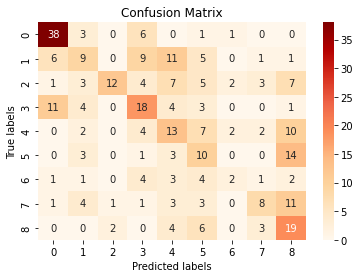

In [10]:
#Predict based on Category: 1-9
main('category')

In [11]:
#Predict based on Performance: Low, Moderate, High
#main('performance')

In [12]:
#Predict based on Potential: Low, Moderate, High
#main('potential')